# Architecture Revision 2

Previously, there was code duplication between the different incremental coefficient optimisers. Here is another integration attempt with the aim to be more granular procedural approach. Key components:

1. Core state objects with extended specs to simulate inheritance, base fields (`x`, `coeff`, `max_features`, `current_features`, `intercept`), for regression additionally (`gramian`, `cholesky`)
2. Reusable functions `add_column` and `add_column_sparse`. Alternatively, since this was also flagged as a potential performance overhead, we consider augmenting the propositionalisation class to write directly into a buffer!
3. Functions `minimum_logistic_loss_coefs` and `minimum_squared_loss_coeffs`
4. Bound together by a higher order function `gradient_sum_boosting_ensemble`


## Test Data

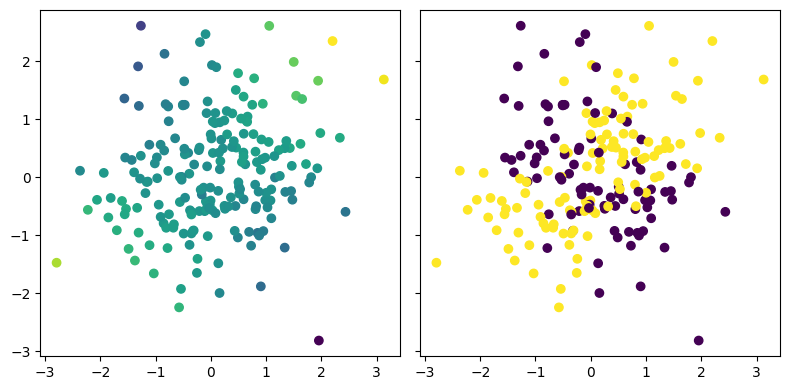

In [4]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(0)

cov = np.array(
    [[1, 0.2], 
     [0.2, 1]]
)

n = 200
x = RNG.multivariate_normal([0, 0], cov, size=n)
y_regr = x[:, 0] * x[:, 1] + RNG.normal(scale=0.25, size=n)
y_class = RNG.binomial(n=1, p=expit(4 * x[:, 0] * x[:, 1]))

_, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
axs[0].scatter(x[:, 0], x[:, 1], c=y_regr)
axs[1].scatter(x[:, 0], x[:, 1], c=y_class)
plt.show()

## Base Boosting Function and Simple Regression Case

In [65]:
import numpy as np
from numba import int64, float64, boolean, njit
from numba.experimental import jitclass
from optikon import max_weighted_support, equal_width_propositionalization
from numba.typed import List

regression_spec_spec = [
    ('y', float64[:]),
    ('x', float64[:, :]),
    ('max_features', int64),
    ('intercept', boolean),
    ('lam', float64)
]

state_spec = [
    ('phi', float64[:, :]),
    ('coef', float64[:]),
    ('current_features', int64),
]

@jitclass(regression_spec_spec)
class RegressionSpec:
    def __init__(self, y, x, max_features, intercept, lam):
        self.y = y
        self.x = x
        self.max_features = max_features
        self.intercept = intercept
        self.lam = lam

@jitclass(state_spec)
class BoostingState:
    def __init__(self, phi, coef, current_features):
        self.phi = phi
        self.coef = coef
        self.current_features = current_features

def init_state(spec):
        phi = np.zeros(shape=(len(spec.y), spec.max_features+spec.intercept))
        if spec.intercept:
            phi[:, 0] = 1
            coef = np.array([spec.y.mean()])
            current_features = 1
        else:
            coef = np.zeros(shape=0)
            current_features = 0
        return BoostingState(phi, coef, current_features)

@njit
def gradient_least_squares(spec, state):
    return state.phi[:, :state.current_features].dot(state.coef) - spec.y

@njit
def fit_least_squares_coefficients(spec, state):
    gramian = state.phi[:, :state.current_features].T.dot(state.phi[:, :state.current_features])

    if spec.lam > 0:
        for i in range(spec.intercept, state.current_features):
            gramian[i, i] += spec.lam
        
    state.coef = np.linalg.solve(gramian, state.phi[:, :state.current_features].T.dot(spec.y))

@njit
def gradient_sum_rule_ensemble(spec, state, props, fit_function, gradient_function, max_depth=5):
    qs = List()
    if spec.intercept:
        qs.append(props[0:0]) 

    for _ in range(spec.max_features):
        g = gradient_function(spec, state)

        opt_key_pos, opt_val_pos, _, _ = max_weighted_support(spec.x, g, props, max_depth)
        opt_key_neg, opt_val_neg, _, _ = max_weighted_support(spec.x, -g, props, max_depth)
        if opt_val_pos >= opt_val_neg:
            qs.append(props[opt_key_pos])
        else:
            qs.append(props[opt_key_neg])

        state.phi[qs[-1].support_all(spec.x), state.current_features] = 1
        state.current_features += 1

        fit_function(spec, state)
    return state.coef, qs

spec = RegressionSpec(y_regr, x, 3, False, 0.0)
state = init_state(spec)
coefs, rules = gradient_sum_rule_ensemble(spec, state, equal_width_propositionalization(spec.x), fit_least_squares_coefficients, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))


1.5036582513481511 x1 >= 0.006 & x2 >= 0.059
-0.8914385667003335 x1 >= -1.864 & x1 <= 1.388 & x2 >= 0.352
0.6744745663809992 x1 <= 0.006 & x2 <= 0.881


## Instantiation for Classification

In [36]:
classification_spec_spec = [
    ('y', int64[:]),
    ('x', float64[:, :]),
    ('max_features', int64),
    ('intercept', boolean),
    ('lam', float64),
    ('max_iter', int64),
    ('tol', float64)
]

@jitclass(classification_spec_spec)
class ClassificationSpec:
    def __init__(self, y, x, max_features, intercept, lam):
        self.y = y
        self.x = x
        self.max_features = max_features
        self.intercept = intercept
        self.lam = lam
        self.max_iter=100
        self.tol=1e-6

cspec = ClassificationSpec(y_class, x, 3, False, 0.0)
cstate = init_state(cspec)

@njit
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

@njit
def gradient_logistic_loss(spec, state):
    return sigmoid(state.phi[:, :state.current_features].dot(state.coef)) - spec.y

@njit
def fit_min_logistic_loss_coefs(spec, state):
    phi = state.phi[:, :state.current_features]
    _, d = phi.shape
    beta = np.zeros(d)
    
    for _ in range(spec.max_iter):
        p = sigmoid(phi.dot(beta))
        grad = phi.T @ (p - spec.y) + 2 * spec.lam * beta
        s = p * (1 - p)
        h = phi.T @ (phi * s[:, None]) + 2 * spec.lam * np.eye(d)
        delta = np.linalg.solve(h, grad)
        beta -= delta
        if np.linalg.norm(delta) < spec.tol:
            break
    state.coef = beta

coefs, rules = gradient_sum_rule_ensemble(cspec, cstate, equal_width_propositionalization(spec.x), fit_min_logistic_loss_coefs, gradient_logistic_loss)

for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))


3.0618651491190625 x1 >= 0.006 & x2 >= 0.059
-1.96544159893931 x1 >= -1.864 & x1 <= 0.923 & x2 >= 0.352
1.4055562089657438 x1 <= 0.006 & x2 <= 0.470


## Instantiation for Incremental Regression Weight Fitting

In [ ]:
import numpy as np
from numba import njit

incremental_ls_spec = [*state_spec,
    ('gram', float64[:, :]),
    ('chol', float64[:, :]),
]

@jitclass(incremental_ls_spec)
class IncrementalLeastSquaresBoostingState:
    def __init__(self, phi, coef, current_features, gram, chol):
        self.phi = phi
        self.coef = coef
        self.current_features = current_features
        self.gram = gram
        self.chol = chol

@njit
def init_incremental_state(spec):
        p = spec.max_features+spec.intercept
        phi = np.zeros(shape=(len(spec.y), p))
        if spec.intercept:
            phi[:, 0] = 1
            coef = np.array([spec.y.mean()])
            current_features = 1
        else:
            coef = np.zeros(shape=0)
            current_features = 0

        g =  np.zeros((p, p))
        l = np.zeros((p, p))
        # b = np.zeros(p)
        return IncrementalLeastSquaresBoostingState(phi, coef, current_features, g, l)

state_incr = init_incremental_state(spec)
print(state_incr)

@njit
def incremental_minimum_squared_loss_coefs(spec, state):
    x, y = state.phi, spec.y
    g, l = state.gram, state.chol
    coef = state.coef
    j = state.current_features - 1

    # Update Gramian
    g[j, :j] = x[:, :j].T @ x[:, j]
    g[:j, j] = g[j, :j]
    g[j, j] = x[:, j] @ x[:, j]

    # Compute RHS
    b = np.zeros(j + 1)
    for i in range(j + 1):
        b[i] = x[:, i] @ y

    # Cholesky update: compute row j of L
    for k in range(j):
        s = 0.0
        for m in range(k):
            s += l[j, m] * l[k, m]
        l[j, k] = (g[j, k] - s) / l[k, k]
    s = 0.0
    for m in range(j):
        s += l[j, m] ** 2
    l[j, j] = np.sqrt(g[j, j] - s)

    # Solve L z = b
    z = np.empty(j+1)
    for i in range(j+1):
        s = 0.0
        for k in range(i):
            s += l[i, k] * z[k]
        z[i] = (b[i] - s) / l[i, i]

    # for i in range(j + 1):
    #     s = 0.0
    #     for k in range(i):
    #         s += l[i, k] * coef[k]
    #     coef[i] = (b[i] - s) / l[i, i]

    # Solve L.T coef = z (in-place on coef)
    state.coef = np.empty(j + 1)
    coef = state.coef
    for i in range(j, -1, -1):
        s = 0.0
        for k in range(i + 1, j + 1):
            s += l[k, i] * coef[k]
        coef[i] = (z[i] - s) / l[i, i]

    # for i in range(j, -1, -1):
    #     s = 0.0
    #     for k in range(i + 1, j + 1):
    #         s += l[k, i] * coef[k]
    #     coef[i] = (coef[i] - s) / l[i, i]

coefs, rules = gradient_sum_rule_ensemble(spec, state_incr, equal_width_propositionalization(spec.x), incremental_minimum_squared_loss_coefs, gradient_least_squares)
for coef, rule in zip(coefs, rules):
    print(coef, rule.str_from_conj(np.arange(len(rule))))

1.5036582513481505 x1 >= 0.006 & x2 >= 0.059
-0.8914385667003333 x1 >= -1.864 & x1 <= 1.388 & x2 >= 0.352
0.674474566380999 x1 <= 0.006 & x2 <= 0.881
